# Data Preparation

## load data

In [1]:
import pandas as pd

data = pd.read_csv('transaction.csv', sep='|')

## feature engineering
this step include date preprocess, categorical encoding and using robust scaler on monetary values

In [2]:
print('transaction data contains ' + str(data.shape[1])
      + " columns with "
      + str(data.select_dtypes(include=np.number).shape[1])
      + " of it numerical, which quite small that it does not need dimensionality reduction")

transaction data contains 29 columns with 17 of it numerical, which quite small that it does not need dimensionality reduction


In [3]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from pandas.api.types import CategoricalDtype


class FeatureProcessor:
    def __init__(self):
        self.monetary_scaler = RobustScaler()
        #         self.available_money_scaler = RobustScaler()
        #         self.transaction_amount_scaler = RobustScaler()
        #         self.current_balance_scaler = RobustScaler()
        self.acq_country_categories = []
        self.merchant_country_code_categories = []
        self.transaction_type_categories = []
        self.pos_entry_mode_categories = []
        self.pos_condition_code_categories = []
        self.merchant_category_code_categories = []

    def fit(self, data):
        self.monetary_scaler.fit(data[['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance']])
        #         self.available_money_scaler.fit(data['availableMoney'])
        #         self.transaction_amount_scaler.fit(data['transactionAmount'])
        #         self.current_balance_scaler.fit(data['currentBalance'])
        self.acq_country_categories = CategoricalDtype(categories=data['acqCountry'].dropna().unique().tolist(),
                                                       ordered=True)
        self.merchant_country_code_categories = CategoricalDtype(categories=data['merchantCountryCode'].
                                                                 dropna().unique().tolist(), ordered=True)
        self.transaction_type_categories = CategoricalDtype(categories=data['transactionType'].
                                                            dropna().unique().tolist(), ordered=True)
        self.pos_entry_mode_categories = CategoricalDtype(categories=data['posEntryMode'].
                                                          dropna().astype('str').unique().tolist(), ordered=True)
        self.pos_condition_code_categories = CategoricalDtype(categories=data['posConditionCode'].
                                                              dropna().astype('str').unique().tolist(), ordered=True)
        self.merchant_category_code_categories = CategoricalDtype(categories=data['merchantCategoryCode'].
                                                                  dropna().unique().tolist(), ordered=True)

    def transform(self, data):
        # drop missing data
        column_dropped = ['merchantCity', 'merchantState', 'merchantZip', 'echoBuffer',
                          'posOnPremises', 'recurringAuthInd']
        new_data = data.drop(columns=column_dropped)
        # dates features
        new_data['transactionDateTime'] = pd.to_datetime(new_data['transactionDateTime'], format="%Y-%m-%dT%H:%M:%S")
        new_data['currentExpDate'] = pd.to_datetime(new_data['currentExpDate'], format="%m/%Y")
        new_data['accountOpenDate'] = pd.to_datetime(new_data['accountOpenDate'], format="%Y-%m-%d")
        new_data['dateOfLastAddressChange'] = pd.to_datetime(new_data['dateOfLastAddressChange'], format="%Y-%m-%d")
        new_data['transactionMonth'] = new_data['transactionDateTime'].dt.strftime("%m").astype('int')
        new_data['transactionDayssOfWeek'] = new_data['transactionDateTime'].dt.strftime("%w").astype('int')
        new_data['transactionHour'] = new_data['transactionDateTime'].dt.strftime("%H").astype('int')
        new_data['expiryFromTransactionDays'] = (new_data['currentExpDate'] - new_data['transactionDateTime']).dt.days
        new_data['expiryFromOpenDays'] = (new_data['currentExpDate'] - new_data['accountOpenDate']).dt.days
        new_data['transactionFromOpenDays'] = (new_data['transactionDateTime'] - new_data['accountOpenDate']).dt.days
        new_data['transactionFromAddressChangeDays'] = (new_data['transactionDateTime']
                                                        - new_data['dateOfLastAddressChange']).dt.days
        new_data['addressChangeFromOpenDays'] = (new_data['dateOfLastAddressChange']
                                                 - new_data['accountOpenDate']).dt.days
        # monetary features
        new_data[['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance']] = \
            self.monetary_scaler.transform(new_data[['creditLimit', 'availableMoney',
                                                     'transactionAmount', 'currentBalance']])
        # new_data['availableMoney'] = self.available_money_scaler.transform(new_data['availableMonet'])
        # new_data['transactionAmount'] = self.transaction_amount_scaler.transform(new_data['transactionAmount'])
        # new_data['currentBalance'] = self.current_balance_scaler.transform(new_data['currentBalance'])
        # card features
        new_data['matchedCVV'] = new_data['cardCVV'] == new_data['enteredCVV']
        # country features
        new_data['countryMatch'] = data['acqCountry'] == data['merchantCountryCode']
        new_data['acqCountry'] = new_data['acqCountry'].astype(self.acq_country_categories)
        new_data = pd.concat([new_data,
                              pd.get_dummies(new_data['acqCountry'],
                                             prefix='acqCountry', dummy_na=True)], axis=1).drop(['acqCountry'], axis=1)
        new_data['merchantCountryCode'] = new_data['merchantCountryCode'].\
            astype(self.merchant_country_code_categories)
        new_data = pd.concat([new_data,
                              pd.get_dummies(new_data['merchantCountryCode'],
                                             prefix='merchantCountryCode', dummy_na=True)], axis=1).\
            drop(['merchantCountryCode'], axis=1)
        # transaction type features
        new_data['transactionType'] = new_data['transactionType'].astype(self.transaction_type_categories)
        new_data = pd.concat([new_data,
                              pd.get_dummies(new_data['transactionType'],
                                             prefix='transactionType',
                                             dummy_na=True)], axis=1).drop(['transactionType'], axis=1)
        # pos code features
        new_data['posEntryMode'] = new_data['posEntryMode'].astype('str').\
            astype(self.pos_entry_mode_categories)
        new_data = pd.concat([new_data,
                              pd.get_dummies(new_data['posEntryMode'],
                                             prefix='posEntryMode',
                                             dummy_na=True)], axis=1).drop(['posEntryMode'], axis=1)
        new_data['posConditionCode'] = new_data['posConditionCode'].astype('str').\
            astype(self.pos_condition_code_categories)
        new_data = pd.concat([new_data,
                              pd.get_dummies(new_data['posConditionCode'],
                                             prefix='posConditionCode',
                                             dummy_na=True)], axis=1).drop(['posConditionCode'], axis=1)
        # merchant features
        new_data['merchantCategoryCode'] = new_data['merchantCategoryCode'].\
            astype(self.merchant_category_code_categories)
        new_data = pd.concat([new_data,
                              pd.get_dummies(new_data['merchantCategoryCode'],
                                             prefix='merchantCategoryCode',
                                             dummy_na=True)], axis=1).drop(['merchantCategoryCode'], axis=1)

        # label encode
        new_data['isFraud'] = new_data['isFraud'] + 0

        # drop unused variable
        new_data = new_data.drop(columns=['accountNumber', 'customerId', 'transactionDateTime', 'currentExpDate',
                                          'accountOpenDate', 'dateOfLastAddressChange', 'merchantName'])

        # return processed data
        return (new_data, new_data.drop(columns=['isFraud']), new_data['isFraud'])


In [4]:
preprocessor = FeatureProcessor()
preprocessor.fit(data)

pre_data, X, y = preprocessor.transform(data)

from
sklearn import svm
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.pipeline import Pipeline
# generate some data to play with
X, y = make_classification(
    n_informative=5, n_redundant=0, random_state=42)
# ANOVA SVM-C
anova_filter = SelectKBest(f_regression, k=5)
clf = svm.SVC(kernel='linear')
anova_svm = Pipeline([('anova', anova_filter), ('svc', clf)])
# You can set the parameters using the names issued
# For instance, fit using a k of 10 in the SelectKBest
# and a parameter 'C' of the svm
anova_svm.set_params(anova__k=10, svc__C=.1).fit(X, y)

prediction = anova_svm.predict(X)
anova_svm.score(X, y)

# getting the selected features chosen by anova_filter
anova_svm['anova'].get_support()



# Another way to get selected features chosen by anova_filter
anova_svm.named_steps.anova.get_support()



# Indexing can also be used to extract a sub-pipeline.
sub_pipeline = anova_svm[:1]
sub_pipeline

coef = anova_svm[-1].coef_
anova_svm['svc'] is anova_svm[-1]

coef.shape

sub_pipeline.inverse_transform(coef).shape


## fix imbalance dataset

In [36]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek

# X_resampled, y_resampled = SMOTE().fit_resample(X, y)


X_resampled, y_resampled = SMOTETomek().fit_resample(X, y)


## train test split

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# XGBoost

## Hyper Parameter Search

In [13]:
from sklearn.model_selection import StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from xgboost import plot_importance
from sklearn.metrics import make_scorer
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval
import time
import xgboost as xgb
import gc


def objective(params):
    time1 = time.time()
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'subsample': "{:.2f}".format(params['subsample']),
        'reg_alpha': "{:.3f}".format(params['reg_alpha']),
        'reg_lambda': "{:.3f}".format(params['reg_lambda']),
        'learning_rate': "{:.3f}".format(params['learning_rate']),
        'num_leaves': '{:.3f}'.format(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'min_child_samples': '{:.3f}'.format(params['min_child_samples']),
        'feature_fraction': '{:.3f}'.format(params['feature_fraction']),
        'bagging_fraction': '{:.3f}'.format(params['bagging_fraction'])
    }

    print("\n############## New Run ################")
    print(f"params = {params}")
    FOLDS = 7
    count = 1
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

    tss = TimeSeriesSplit(n_splits=FOLDS)
    # y_preds = np.zeros(sample_submission.shape[0])
    # y_oof = np.zeros(X_train.shape[0])
    score_mean = 0
    for tr_idx, val_idx in tss.split(X_train, y_train):
        clf = xgb.XGBClassifier(
            n_estimators=600, random_state=4, verbose=True,
            tree_method='gpu_hist',
            **params
        )

        X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
        y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]

        clf.fit(X_tr, y_tr)
        # y_pred_train = clf.predict_proba(X_vl)[:,1]
        # print(y_pred_train)
        score = make_scorer(roc_auc_score, needs_proba=True)(clf, X_vl, y_vl)
        # plt.show()
        score_mean += score
        print(f'{count} CV - score: {round(score, 4)}')
        count += 1
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2 / 60,2)}")
    gc.collect()
    print(f'Mean ROC_AUC: {score_mean / FOLDS}')
    del X_tr, X_vl, y_tr, y_vl, clf, score
    return -(score_mean / FOLDS)


space = {
    # The maximum depth of a tree, same as GBM.
    # Used to control over-fitting as higher depth will allow model
    # to learn relations very specific to a particular sample.
    # Should be tuned using CV.
    # Typical values: 3-10
    'max_depth': hp.quniform('max_depth', 7, 23, 1),

    # reg_alpha: L1 regularization term. L1 regularization encourages sparsity
    # (meaning pulling weights to 0). It can be more useful when the objective
    # is logistic regression since you might need help with feature selection.
    'reg_alpha': hp.uniform('reg_alpha', 0.01, 0.4),

    # reg_lambda: L2 regularization term. L2 encourages smaller weights, this
    # approach can be more useful in tree-models where zeroing
    # features might not make much sense.
    'reg_lambda': hp.uniform('reg_lambda', 0.01, .4),

    # eta: Analogous to learning rate in GBM
    # Makes the model more robust by shrinking the weights on each step
    # Typical final values to be used: 0.01-0.2
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),

    # colsample_bytree: Similar to max_features in GBM. Denotes the
    # fraction of columns to be randomly samples for each tree.
    # Typical values: 0.5-1
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, .9),

    # A node is split only when the resulting split gives a positive
    # reduction in the loss function. Gamma specifies the
    # minimum loss reduction required to make a split.
    # Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.
    'gamma': hp.uniform('gamma', 0.01, .7),

    # more increases accuracy, but may lead to overfitting.
    # num_leaves: the number of leaf nodes to use. Having a large number
    # of leaves will improve accuracy, but will also lead to overfitting.
    'num_leaves': hp.choice('num_leaves', list(range(20, 250, 10))),

    # specifies the minimum samples per leaf node.
    # the minimum number of samples (data) to group into a leaf.
    # The parameter can greatly assist with overfitting: larger sample
    # sizes per leaf will reduce overfitting (but may lead to under-fitting).
    'min_child_samples': hp.choice('min_child_samples', list(range(100, 250, 10))),

    # subsample: represents a fraction of the rows (observations) to be
    # considered when building each subtree. Tianqi Chen and Carlos Guestrin
    # in their paper A Scalable Tree Boosting System recommend
    'subsample': hp.choice('subsample', [0.2, 0.4, 0.5, 0.6, 0.7, .8, .9]),

    # randomly select a fraction of the features.
    # feature_fraction: controls the subsampling of features used
    # for training (as opposed to subsampling the actual training data in
    # the case of bagging). Smaller fractions reduce overfitting.
    'feature_fraction': hp.uniform('feature_fraction', 0.4, .8),

    # randomly bag or subsample training data.
    'bagging_fraction': hp.uniform('bagging_fraction', 0.4, .9)

    # bagging_fraction and bagging_freq: enables bagging (subsampling)
    # of the training data. Both values need to be set for bagging to be used.
    # The frequency controls how often (iteration) bagging is used. Smaller
    # fractions and frequencies reduce overfitting.
}

### Set algoritm parameters
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=27)


### Print best parameters
best_params = space_eval(space, best)

## Train and Test non SMOTE

In [16]:
best_params = {'bagging_fraction': 0.42125209181922985,
               'colsample_bytree': 0.6604000269557071,
               'feature_fraction': 0.6521631863919439,
               'gamma': 0.010123197853081717,
               'learning_rate': 0.013224200479398276,
               'max_depth': 13,
               'min_child_samples': 200,
               'num_leaves': 110,
               'reg_alpha': 0.23568010861071798,
               'reg_lambda': 0.17200619646922866,
               'subsample': 0.8}

In [18]:
clf = xgb.XGBClassifier(
    n_estimators=300,
    **best_params
)

clf.fit(X_train, y_train)


XGBClassifier(bagging_fraction=0.42125209181922985, base_score=0.5,
              booster='gbtree', colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6604000269557071,
              feature_fraction=0.6521631863919439, gamma=0.010123197853081717,
              learning_rate=0.013224200479398276, max_delta_step=0,
              max_depth=13, min_child_samples=200, min_child_weight=1,
              missing=None, n_estimators=300, n_jobs=1, nthread=None,
              num_leaves=110, objective='binary:logistic', random_state=0,
              reg_alpha=0.23568010861071798, reg_lambda=0.17200619646922866,
              scale_pos_weight=1, seed=None, silent=None, subsample=0.8,
              verbosity=1)

In [24]:
y_preds_prob = clf.predict_proba(X_test)[:, 1]
y_preds = clf.predict(X_test)

### Test score and confusion matrix

ROC AUC score for data : 0.7915 
Confusion matrix, without normalization
[[189133      0]
 [  3440      2]]
Normalized confusion matrix
[[1.00000000e+00 0.00000000e+00]
 [9.99418942e-01 5.81057525e-04]]


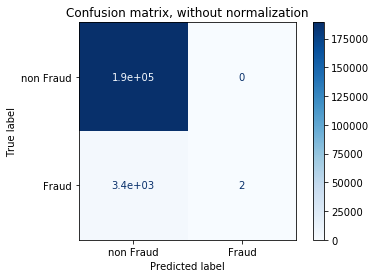

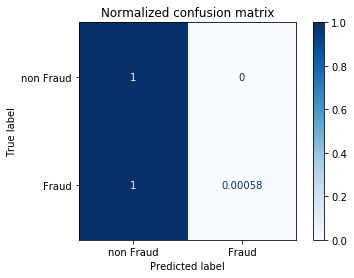

In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

print('ROC AUC score for data : {0:0.4f} '.format(roc_auc_score(y_test, y_preds_prob)))
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=['non Fraud', 'Fraud'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

### Feature Importance

In [33]:
feature_important = clf.get_booster().get_score(importance_type="weight")
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)

# Top 10 features
data.head(20)

,score
transactionAmount,20709
transactionFromOpenDays,15932
availableMoney,14633
expiryFromTransactionDays,14553
currentBalance,14455
expiryFromOpenDays,12728
transactionFromAddressChangeDays,12467
cardLast4Digits,12099
cardCVV,11815
transactionHour,9656


## Train and Test SMOTE

In [37]:
X_orig = X
y_orig = y

X = X_resampled
y = y_resampled

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [38]:
best_params = {clf_SMOTEging_fraction': 0.42125209181922985,
               'colsample_bytree': 0.6604000269557071,
               'feature_fraction': 0.6521631863919439,
               'gamma': 0.010123197853081717,
               'learning_rate': 0.013224200479398276,
               'max_depth': 13,
               'min_child_samples': 200,
               'num_leaves': 110,
               'reg_alpha': 0.23568010861071798,
               'reg_lambda': 0.17200619646922866,
               'subsample': 0.8}

In [39]:
clf_SMOTE = xgb.XGBClassifier(
    n_estimators=300,
    **best_params
)

clf_SMOTE.fit(X_train, y_train)


XGBClassifier(bagging_fraction=0.42125209181922985, base_score=0.5,
              booster='gbtree', colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6604000269557071,
              feature_fraction=0.6521631863919439, gamma=0.010123197853081717,
              learning_rate=0.013224200479398276, max_delta_step=0,
              max_depth=13, min_child_samples=200, min_child_weight=1,
              missing=None, n_estimators=300, n_jobs=1, nthread=None,
              num_leaves=110, objective='binary:logistic', random_state=0,
              reg_alpha=0.23568010861071798, reg_lambda=0.17200619646922866,
              scale_pos_weight=1, seed=None, silent=None, subsample=0.8,
              verbosity=1)

In [44]:
y_preds_prob = clf_SMOTE.predict_proba(X_test)[:, 1]
y_preds = clf_SMOTE.predict(X_test)

### Test score and confusion matrix

ROC AUC score for data : 0.9961 
Confusion matrix, without normalization
[[186385   1909]
 [  5575 182762]]
Normalized confusion matrix
[[0.9898616  0.0101384 ]
 [0.02960119 0.97039881]]


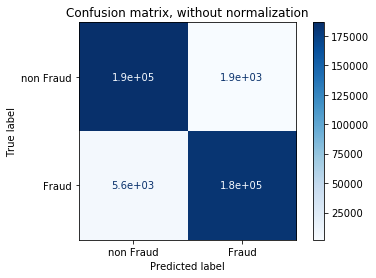

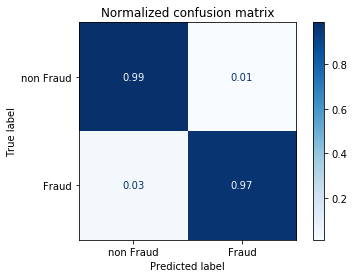

In [45]:
print('ROC AUC score for data : {0:0.4f} '.format(roc_auc_score(y_test, y_preds_prob)))
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_SMOTE, X_test, y_test,
                                 display_labels=['non Fraud', 'Fraud'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

ROC AUC score for original data : 0.8853 
Confusion matrix, without normalization
[[624957   5655]
 [  9016   2286]]
Normalized confusion matrix
[[0.99103252 0.00896748]
 [0.79773491 0.20226509]]


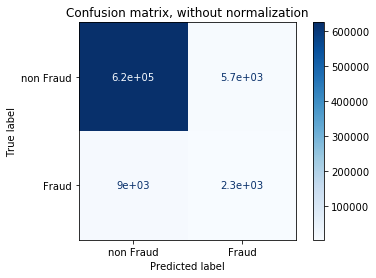

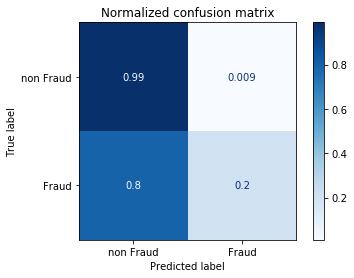

In [46]:
print('ROC AUC score for original data : {0:0.4f} '.format(roc_auc_score(y_orig,  clf_SMOTE.predict_proba(X_orig)[:, 1])))
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_SMOTE, X_orig, y_orig,
                                 display_labels=['non Fraud', 'Fraud'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

### Feature Importance

In [47]:
feature_important = clf_SMOTE.get_booster().get_score(importance_type="weight")
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)

# Top 10 features
data.head(20)

,score
cardLast4Digits,42452
expiryFromOpenDays,40585
expiryFromTransactionDays,40425
transactionFromOpenDays,36653
transactionAmount,32459
cardCVV,31697
transactionFromAddressChangeDays,30357
availableMoney,29056
currentBalance,28892
creditLimit,24272
